# Outliers analysis

In order to check order outliers in dataframe, has been used Isolation Forest machine learning model. It has been setted with custom threshold 0.05, but it's possible to change it as need.

From the point of view of an economic analysis, the analysis of outlier values can be useful to identify potential variables that may go unnoticed because they are contained in a consistent set of data.

The following analysis will display both dataframes and graphs in order to make interpretation easier and faster.

### SetUp

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import ccf

**IMPORTANT: following will be pasted screenshot of some outputs you  get from udf, because GitHub does not print colors mapping.**

### Read datasets

In [2]:
def read_gdrive_to_df(file_id):
    """
    Read an Excel file from Google Drive using its file ID and return a DataFrame.
    """
    base_url = f'https://drive.google.com/file/d/{file_id}/view?usp=sharing'
    download_url = 'https://drive.google.com/uc?id=' + base_url.split('/')[-2]
    return pd.read_excel(download_url, index_col=0)

# File IDs
df_mean_distance_link = '10iqaD8LEWDXpb1qKfHNNvNdVvODkW1Ap'

# Read files using the function
df_mean_distance = read_gdrive_to_df(df_mean_distance_link) # mean distance from year for each country

### Datasets explanation
- df_normalize: data normalized (zscore) + made difference from previous data (.diff)
- df_mean_distance: by df_normalized has been calculated for each sigle country and year the distance by mean for each year compared to the total years

**Following will be used:** df_mean_distance

### Check data distribution

In [3]:
def plot_data_distribution(df, exclude_columns=[], plots_per_row=2):
    df_numeric = df.select_dtypes(include=[np.number])

    # Remove the specified columns from the analysis
    df_numeric = df_numeric.drop(columns=exclude_columns, errors='ignore')

    # Extract all columns without the extension "_outlier"
    original_columns = [col for col in df_numeric.columns if not col.endswith('_outlier')]

    # Calculate the number of rows needed
    num_rows = int(np.ceil(len(original_columns) / plots_per_row))
    
    # Initialize the subplots
    fig, axes = plt.subplots(num_rows, plots_per_row, figsize=(15, 5 * num_rows))
    
    if num_rows == 1:
        axes = np.expand_dims(axes, axis=0)
    
    for idx, column in enumerate(original_columns):
        row = idx // plots_per_row
        col = idx % plots_per_row
        
        # Get the values of the original column
        original_values = df[column]
        
        # Plot the values
        axes[row, col].scatter(original_values.index, original_values, color='b', label='Data', alpha=0.7)
        
        # Add title and legend
        axes[row, col].set_title(f'Scatter Plot for Column "{column}"')
        axes[row, col].set_xlabel('Index')
        axes[row, col].set_ylabel(column)
        axes[row, col].legend()
    
    # Remove any empty plots
    for idx in range(len(original_columns), num_rows * plots_per_row):
        fig.delaxes(axes.flatten()[idx])

    plt.tight_layout()
    plt.show()

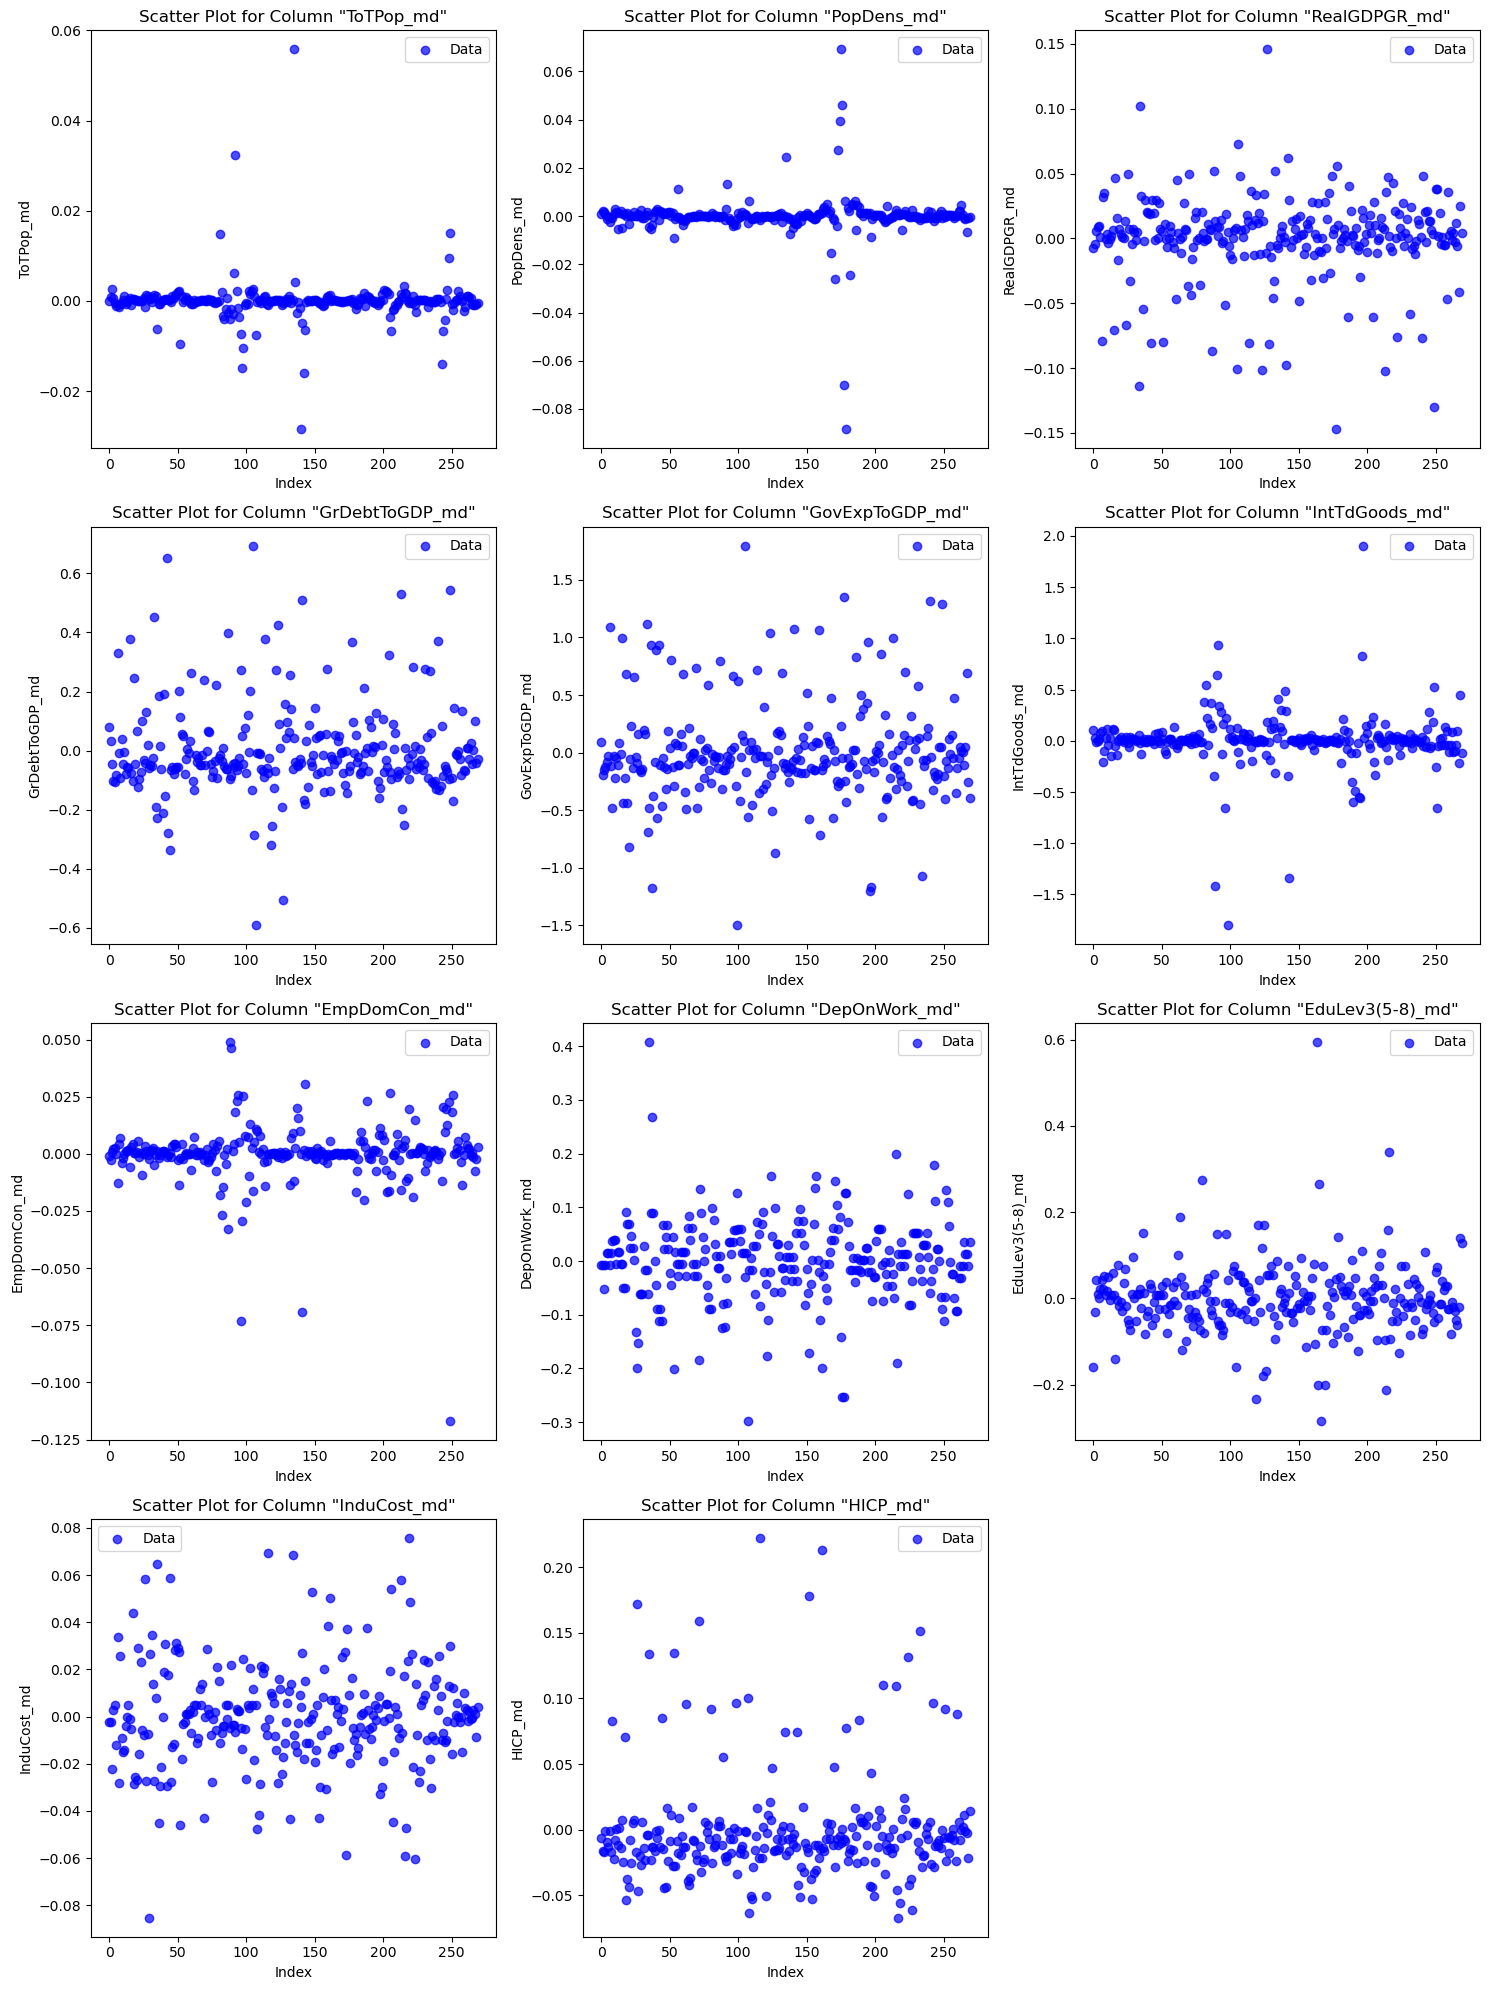

In [5]:
# Call
plot_data_distribution(df_mean_distance, exclude_columns=['year'], plots_per_row=3)

### IsolationForest model application</u> [sklearn official page](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.IsolationForest.html)

Following will be used Isolation Forest model to get potentially outliers. Thre threshold setted is done by dataframe knowledge, but if you prefer doing analysis to define thresholdshold you could use F1 score.

In [35]:
from sklearn.ensemble import IsolationForest

def isolation_forest(df, 
                     exclude_columns=None, 
                     group_column=None, 
                     replace_nan_with_zero=False, 
                     replace_values_with_zero=None, 
                     threshold="auto"):

    if replace_values_with_zero is None:
        replace_values_with_zero = []

    # Convert categorical columns to string columns
    for col in df.select_dtypes(include=['category']).columns:
        df[col] = df[col].astype('str')

    # Replace specified values and NaN with 0, if requested
    if replace_nan_with_zero:
        df = df.fillna(0)
    
    for value in replace_values_with_zero:
        df.replace(value, 0, inplace=True)
    
    if exclude_columns is None:
        exclude_columns = []

    # Select numeric columns, excluding specified columns
    df_numeric = df.select_dtypes(include=[np.number]).drop(columns=exclude_columns)

    # Copy of the original dataframe
    df_total_col = df.copy()

    # Number of trees in Isolation Forest
    n_estimators = 100

    # DataFrame to save the predicted columns
    outliers_IsoFor = pd.DataFrame(index=df.index)

    # Create an Isolation Forest object
    isolation_forest = IsolationForest(n_estimators=n_estimators, contamination=threshold, random_state=1991)

    if group_column:
        for group_value, group in df.groupby(group_column):
            for column in df_numeric.columns:
                X = group[column].values.reshape(-1, 1)
                outlier_predictions = isolation_forest.fit_predict(X)

                # Save predictions in the output DataFrame
                outliers_IsoFor.loc[group.index, column + '_outlier'] = outlier_predictions
    else:
        for column in df_numeric.columns:
            X = df[column].values.reshape(-1, 1)
            outlier_predictions = isolation_forest.fit_predict(X)

            # Save predictions in the output DataFrame
            outliers_IsoFor[column + '_outlier'] = outlier_predictions

    # Add the predicted columns to the original dataframe
    df_iso_for = pd.concat([df_total_col, outliers_IsoFor], axis=1)

    return df_iso_for

In [36]:
df_isofor_outliers = isolation_forest(df_mean_distance, 
                     exclude_columns='year', 
                     group_column=None, 
                     replace_nan_with_zero=False, 
                     replace_values_with_zero=None, 
                     threshold=0.05)

**Data Modelling**

In [37]:
def iso_for_alternate_columns(df, exclude_columns=[]):
    df_category = df.select_dtypes(exclude=[np.number])
    df_numeric = df.select_dtypes(include=[np.number])
    
    # Rimuovere le colonne specificate dall'analisi
    df_numeric = df_numeric.drop(columns=exclude_columns, errors='ignore')
    df_category = df_category.drop(columns=exclude_columns, errors='ignore')

    # Round column values with the extension '_outlier' to 0 decimal places
    for col in df_numeric.columns:
        if col.endswith('_outlier'):
            df_numeric[col] = df_numeric[col]

    # Create a blank list to store alternate columns
    alternating_columns = []

    # Extract all columns without the extension "_outlier"
    original_columns = [col for col in df_numeric.columns if not col.endswith('_outlier')]

    # Cycle through the original columns
    for column in original_columns:
        # Aggiungi la colonna originale
        alternating_columns.append(column)

        # Add the corresponding "_outlier" column only if it exists
        outlier_column = column + '_outlier'
        if outlier_column in df.columns:
            alternating_columns.append(outlier_column)

    # Create a new DataFrame using the desired column order
    alternating_df = df[alternating_columns]
    df_iso_for = pd.concat([df_category, alternating_df], axis=1)
    
    def style_outliers(data):
        styles = ['font-weight: bold' if (val == -1 and '_outlier' in col) else '' for val, col in zip(data, data.index)]
        return styles

    # Apply the styling function to the entire DataFrame
    df_iso_for_styled = df_iso_for.style.apply(style_outliers, axis=1)
    display(df_iso_for_styled)

    return df_iso_for

In [38]:
# First time you print thid udf will showed up outliers (-1) highlited
pd.options.display.float_format = '{:.2f}'.format
df_iso_for = iso_for_alternate_columns(df_isofor_outliers, exclude_columns=[])

# Screenshot posted to show example outliers found

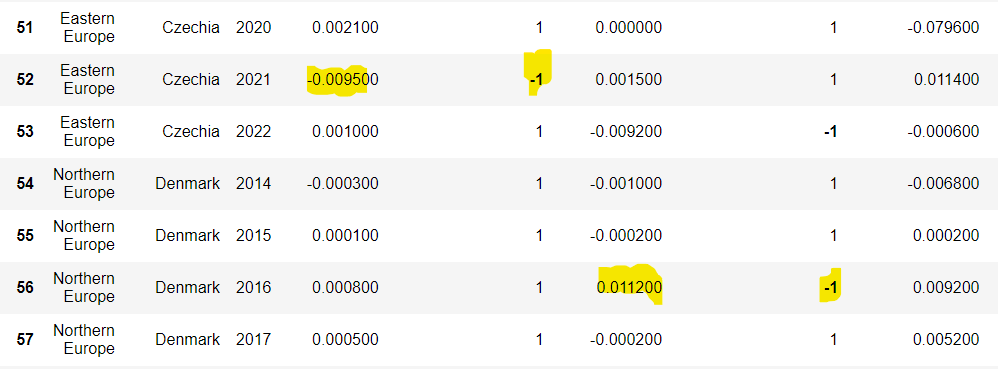

### Graph data distribution and outliers highlited

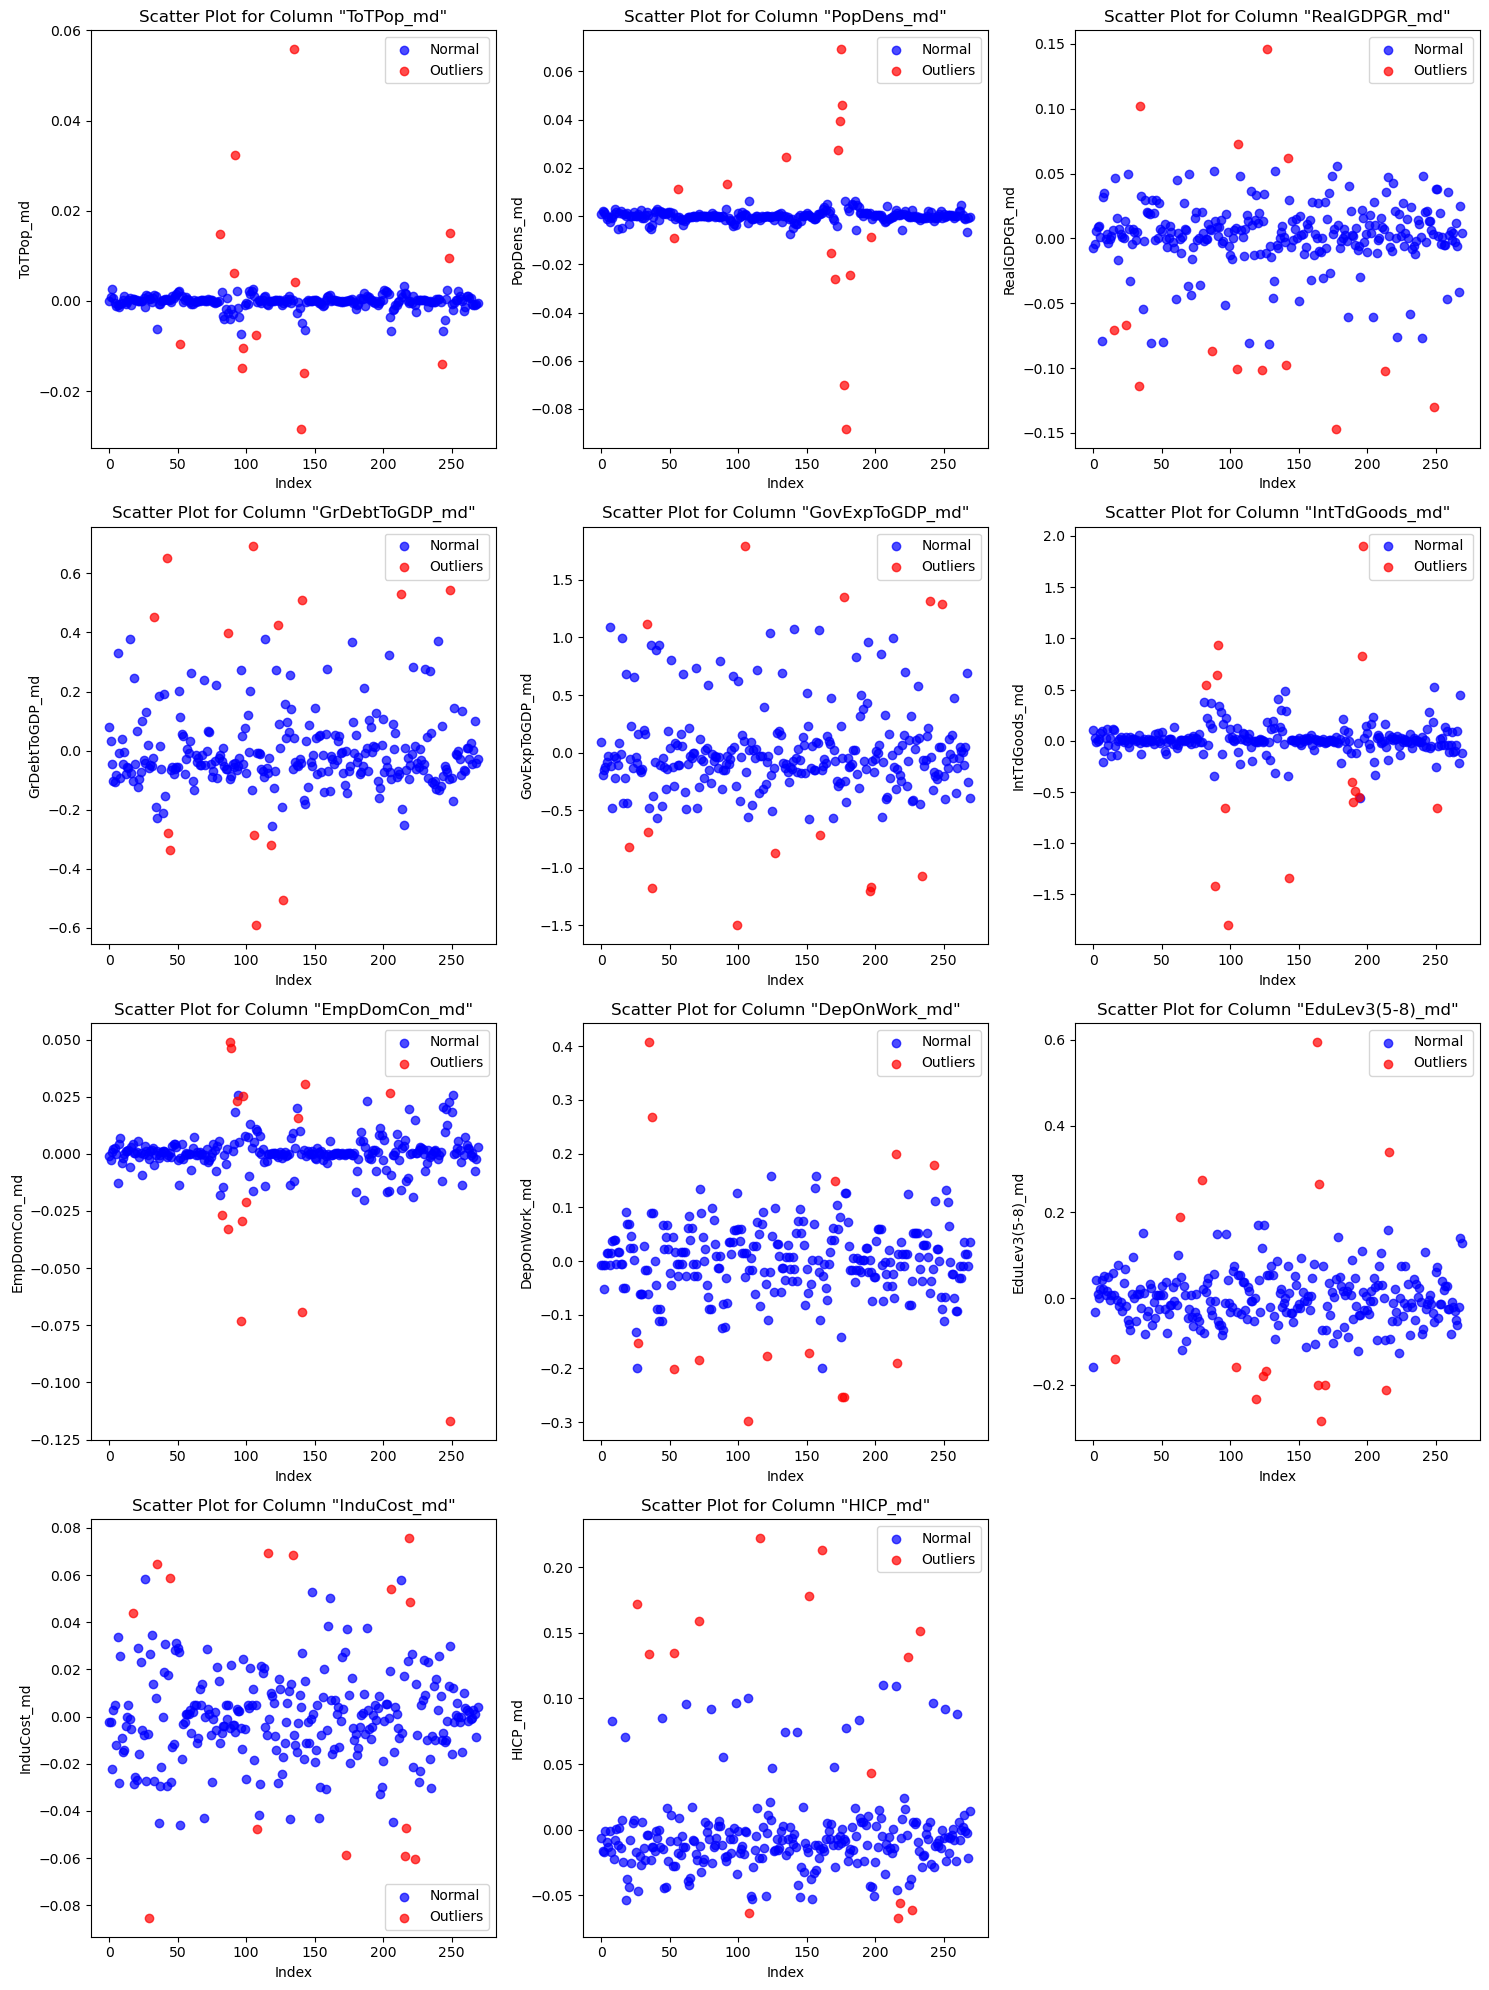

In [39]:
import matplotlib.pyplot as plt
import numpy as np

# Graph data distribution and outliers highlighted
def plot_outliers_scatter(df, exclude_columns=[], plots_per_row=2):
    df_numeric = df.select_dtypes(include=[np.number])

    # Remove the specified columns from the analysis
    df_numeric = df_numeric.drop(columns=exclude_columns, errors='ignore')

    # Extract all columns without the extension "_outlier"
    original_columns = [col for col in df_numeric.columns if not col.endswith('_outlier')]

    # Calculate the number of rows needed
    num_rows = int(np.ceil(len(original_columns) / plots_per_row))
    
    # Initialize the subplots
    fig, axes = plt.subplots(num_rows, plots_per_row, figsize=(15, 5 * num_rows))

    if num_rows == 1:
        axes = np.expand_dims(axes, axis=0)

    for idx, column in enumerate(original_columns):
        row = idx // plots_per_row
        col = idx % plots_per_row

        # Check if the corresponding "_outlier" column exists
        outlier_column = column + '_outlier'
        if outlier_column in df.columns:

            #  Get original column and outlier column values
            original_values = df[column]
            outlier_values = df[outlier_column]

            # Mask for values and outliers
            mask_normal = outlier_values == 1
            mask_outliers = outlier_values == -1

            # Plot normal values
            axes[row, col].scatter(original_values[mask_normal].index, original_values[mask_normal], color='b', label='Normal', alpha=0.7)

            # Plots outliers
            axes[row, col].scatter(original_values[mask_outliers].index, original_values[mask_outliers], color='r', label='Outliers', alpha=0.7)

            # Add title and legend
            axes[row, col].set_title(f'Scatter Plot for Column "{column}"')
            axes[row, col].set_xlabel('Index')
            axes[row, col].set_ylabel(column)
            axes[row, col].legend()

    # Remove empty plots
    for idx in range(len(original_columns), num_rows * plots_per_row):
        fig.delaxes(axes.flatten()[idx])

    plt.tight_layout()
    plt.show()

# Call
plot_outliers_scatter(df_isofor_outliers, exclude_columns=['year'], plots_per_row=3)

### Show datafram with just outliers

In [40]:
def outliers_df_iso_for(df, exclude_columns=None):
    if exclude_columns is None:
        exclude_columns = []
    
    outlier_columns = [col for col in df.columns if col.endswith('_outlier') and col not in exclude_columns]

    # Loop through outlier column indexes
    for col in outlier_columns:
        original_col_idx = df.columns.get_loc(col) - 1 # Index to previous column
        original_col = df.columns[original_col_idx] # Name of previous column

        if original_col not in exclude_columns:
            mask = df[col] == 1 # Create a mask where the values in the outlier column are 1
            df.loc[mask, original_col] = np.nan # Replace the corresponding values in the original column with Nan

    # Copy the dataframe and remove columns with the extension "_outlier"
    df_outlier = df.copy()
    df_outlier = df_outlier.drop(columns=outlier_columns)
    
    return df_outlier

# Call
df_outlier = outliers_df_iso_for(df_iso_for, exclude_columns=[]) # 'year' already passed previously

In [41]:
df_outlier.head()

,geo,country,year,ToTPop_md,PopDens_md,RealGDPGR_md,GrDebtToGDP_md,GovExpToGDP_md,IntTdGoods_md,EmpDomCon_md,DepOnWork_md,EduLev3(5-8)_md,InduCost_md,HICP_md
0,Western Europe,Austria,2014.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.16,NaN,NaN
1,Western Europe,Austria,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Western Europe,Austria,NaN,0.00,NaN,NaN,NaN,NaN,NaN,NaN,-0.05,NaN,NaN,NaN
3,Western Europe,Austria,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Western Europe,Austria,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Box plot: quantity and size of outliers

Outliers or No Outliers: Outliers


C:\Users\utente\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\utente\anaconda3\Lib\site-packages\seaborn\categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)
C:\Users\utente\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\utente\anaconda3\Lib\site-packages\seaborn\categorical.py:641: FutureWarning: The default of observed=False is deprecated and will

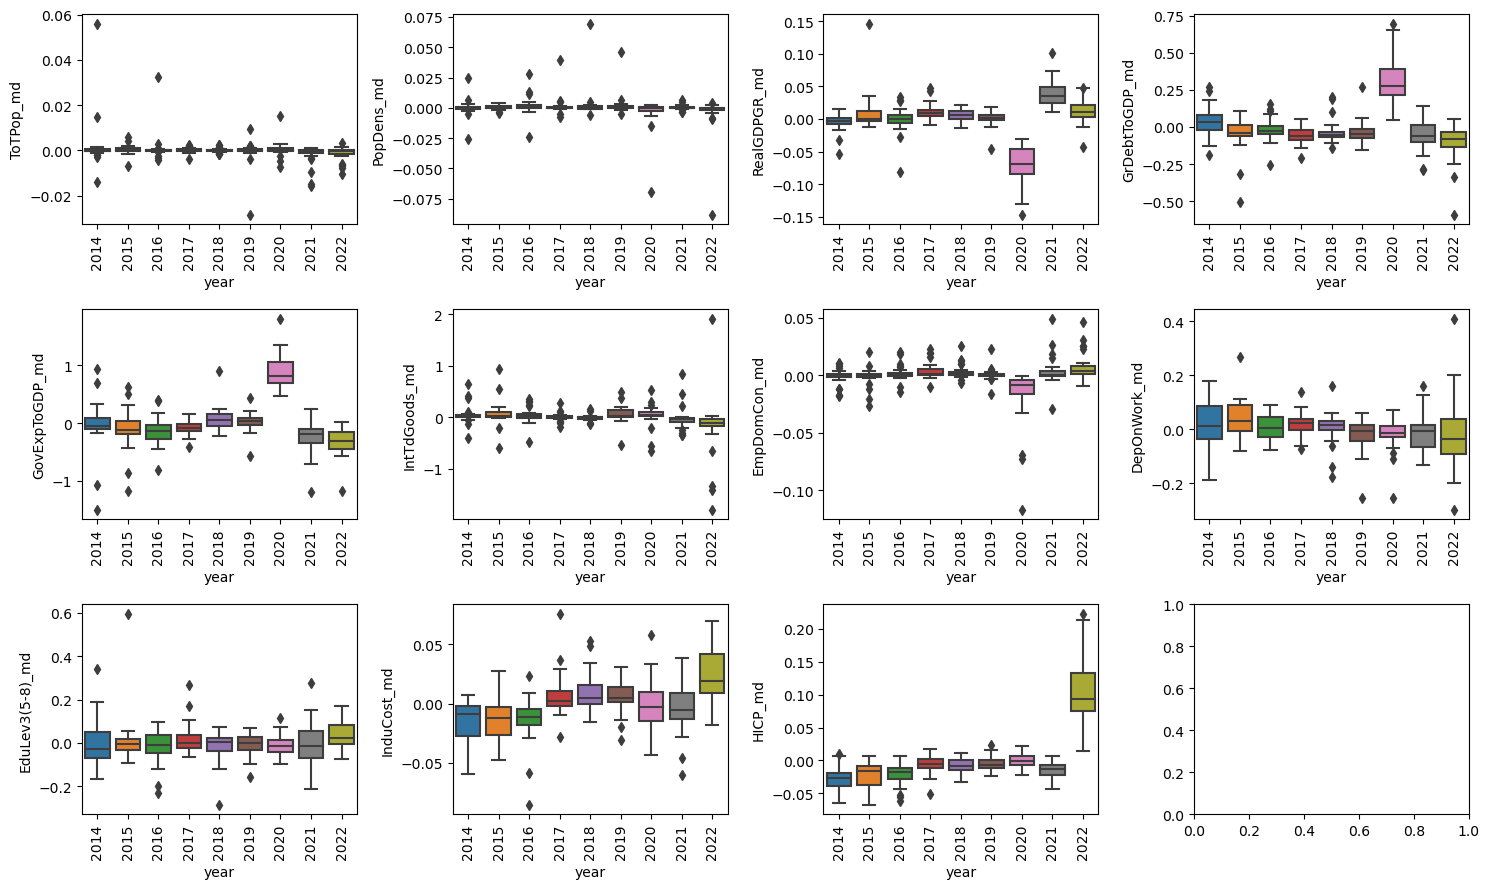

In [44]:
# NOTE, make sure that:
# - 'df_outlier' only contain outliers
# - select df normalized with mean distance by each country

import math
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def Boxplot_DataDistribution(time_column, df, df_outliers, exclude_columns=[]):
    
    df_copy = df.copy()
    df_copy[time_column] = df_copy[time_column].astype('category')
    
    # Option plotting
    selection = None
    while selection not in ['Outliers', 'No Outliers']:
        selection = input('Outliers or No Outliers: ')
        if selection not in ['Outliers', 'No Outliers']:
            print('Try again with options available')
    
    # Remove outliers for 'No Outliers'
    if selection == 'No Outliers':
        mask = df_outliers.select_dtypes(include=[np.number]).notna()
        for col in mask.columns:
            if col in df_copy.columns and col != time_column and col not in exclude_columns:
                df_copy[col] = df_copy[col].where(mask[col] == False)

    
    selected_columns = df_copy.select_dtypes(include=[np.number]).drop(columns=[time_column] + exclude_columns, errors='ignore').columns

    # Seleziona tutte le colonne tranne "year"
    
    n = len(selected_columns)
    ncols = 4
    nrows = math.ceil(n / ncols)  # Calcola il numero di righe necessarie

    fig, axs = plt.subplots(nrows, ncols, figsize=(15, 3*nrows))  # Aumenta la dimensione verticale in base al numero di righe

    for i, ax in enumerate(axs.flat):  
        if i < n:  
            x_data = df_copy[time_column]
            y_data = df_copy[selected_columns[i]]

            if x_data.dropna().shape[0] == 0:
                print(f"x_data in column {selected_columns[i]} contains no values")
            if y_data.dropna().shape[0] == 0:
                print(f"y_data in column {selected_columns[i]} contains no values")

            if x_data.dropna().shape[0] > 0 and y_data.dropna().shape[0] > 0:
                sns.boxplot(x=x_data, y=y_data, ax=ax)
                ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
            else:
                ax.set_visible(False)
                
    plt.tight_layout()  # Regola l'impaginazione per evitare sovrapposizioni
    plt.show()

    return

Boxplot_DataDistribution('year', df_mean_distance, df_outlier,exclude_columns=['year'])

### Bubble graph (bigger means more outliers found in column)

Percentage outliers found for each column


year              0.11
ToTPop_md         0.11
PopDens_md        0.10
RealGDPGR_md      0.11
GrDebtToGDP_md    0.11
GovExpToGDP_md    0.11
IntTdGoods_md     0.11
EmpDomCon_md      0.11
DepOnWork_md      0.09
EduLev3(5-8)_md   0.11
InduCost_md       0.11
HICP_md           0.11
dtype: float64

Average outliers found: 0.11


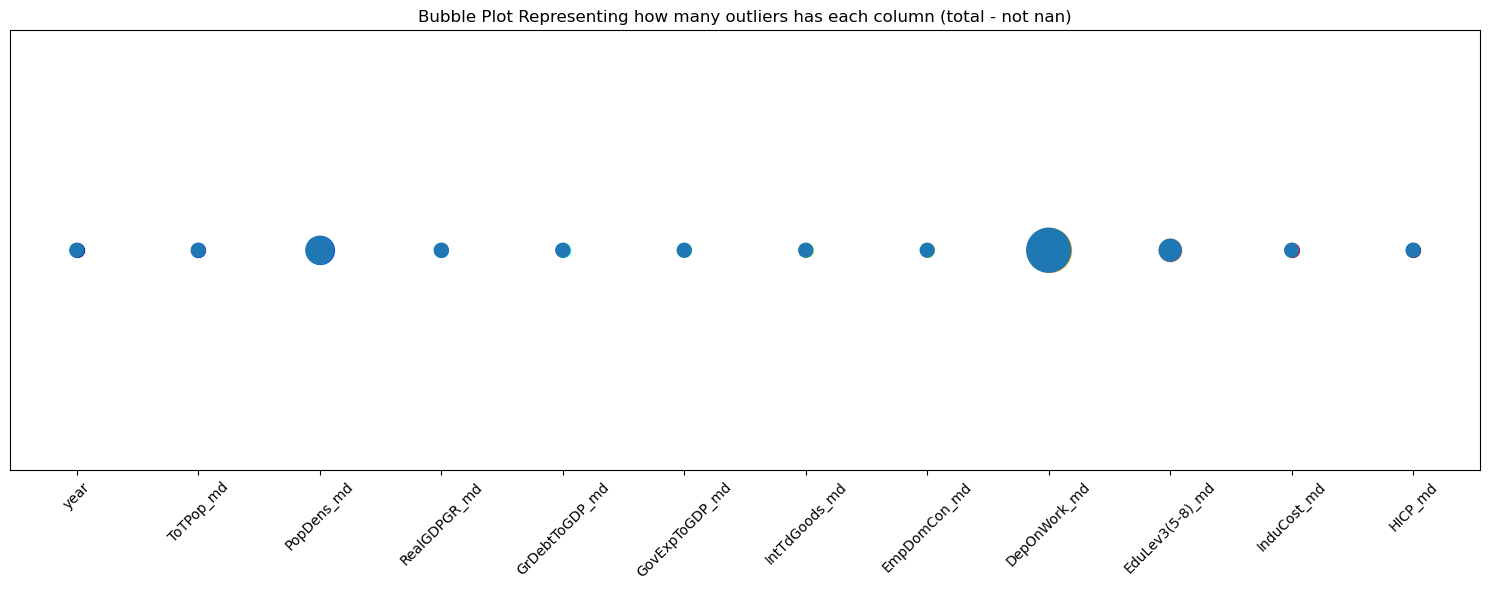

In [46]:
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

def outliers_df_outliers_presence(df, exclude_columns=[]):
    df_numeric = df.select_dtypes(include=[np.number])

    # Remove the specified columns from the analysis
    df_numeric = df_numeric.drop(columns=exclude_columns, errors='ignore')

    # Calculate the size of bubbles
    nan_count = df_numeric.isna().sum()
    not_nan_count = df_numeric.count()
    total_count = nan_count + not_nan_count
    bubble_sizes = total_count - not_nan_count
    
    # --- TABLE
    print('Percentage outliers found for each column')
    fraction_outliers = not_nan_count/total_count
    display(fraction_outliers.round(2))
    
    # Show the overall average
    mean_outliers = fraction_outliers.mean()
    print(f'Average outliers found: {mean_outliers:.2f}')

    # --- PLOT
    # Resize bubble sizes in a specific range (e.g. 100-1000)
    scaler = MinMaxScaler(feature_range=(100, 1000))
    bubble_sizes_scaled = scaler.fit_transform(bubble_sizes.values.reshape(-1, 1))
    
    # Create a Bubble Chart
    plt.figure(figsize=(15, 6))
    colors = plt.cm.jet(np.linspace(0, 1, len(bubble_sizes))) # Color map

    for idx, size in enumerate(bubble_sizes_scaled):
        plt.scatter(idx, 1, s=size, color=colors[idx], label=bubble_sizes.index[idx]) # Bubble with unique color

    # Create graph
    plt.scatter(range(len(bubble_sizes)), [1] * len(bubble_sizes), s=bubble_sizes_scaled)
    plt.xticks(range(len(bubble_sizes)), bubble_sizes.index, rotation=45) # Labels for the x axis
    plt.yticks([]) # Removes ticks on the y-axis
    plt.title('Bubble Plot Representing how many outliers has each column (total - not nan)')
    plt.tight_layout() # Ensures Labels are not cut
    plt.show()

# Call
outliers_df_outliers_presence(df_outlier, exclude_columns=[])